Есть 3 датасета
1. Размеченный руками, маленький, из трёх разных проектов. 2800 примеров (код - комментарий - is coherence).
2. Большой из статьи про генерацию комментариев.
3. Средний из статьи про генерацию комментариев из техаса, только комментарии про return. 

# Загрузка данных (на диск)

In [ ]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [ ]:
file_id = '1r0qA2CHQs17M7hcqZVlet9I8-Cup4I8y'
destination = 'common.py'
download_file_from_google_drive(file_id, destination)

In [ ]:
file_id = '1mp4E60gRq6DOHJNEB1gp_WHvHarR0qoz'
destination = 'dataset.py'
download_file_from_google_drive(file_id, destination)

In [ ]:
file_id = '1RJdYuq_0qlNVEwjAm9JjMCckOh4zsFMH'
destination = 'vocab.py'
download_file_from_google_drive(file_id, destination)

In [ ]:
import os
file_id = '1VUWt9LV_ury9EqWapr37GbFBAlsvM-Jb'
os.mkdir('CUP')
destination = 'CUP/mix_vocab_embeddings.pkl'
download_file_from_google_drive(file_id, destination)

In [ ]:
file_id = '1BC4GKnWDQwfYkGCnAvubD3XElEs3iRmN'
destination = 'CUP/mix_vocab.json'
download_file_from_google_drive(file_id, destination)

In [ ]:
file_id = '1YdJIgDz-sCWoGDZ5h0HwSzSRBIvFqyZl'
destination = 'CUP/test.json'
download_file_from_google_drive(file_id, destination)

In [ ]:
file_id = '1r_FzyO-oHIWeeDUDrAciR707wd1ZczJO'
destination = 'CUP/train.json'
download_file_from_google_drive(file_id, destination)

In [ ]:
file_id = '1cxEo7ZxDmvDy4ECqfDtV9hXorFeR6QPM'
destination = 'CUP/vocab.json'
download_file_from_google_drive(file_id, destination)

In [ ]:
file_id = '1jpi-KTVjKDoDzdS8u0aeNVi3O-iRt_s0'
destination = 'CUP/vocab_embeddings.pkl'
download_file_from_google_drive(file_id, destination)

In [ ]:
# Данные CUP загружены в colab

In [ ]:
os.mkdir('texas')

In [ ]:
# checkout https://drive.google.com/drive/folders/12VMmdE67bp5UFYIoBUf0ibKGXFCH6fQo
file_id = '1bUtfE5pBmkxtqAluYN4Mo2_bIjXPA8S9'
destination = 'texas/train.json'
download_file_from_google_drive(file_id, destination)
file_id = '1Tv9_Rgbt08O9aUJvxjRT4b537VyFf0sh'
destination = 'texas/test.json'
download_file_from_google_drive(file_id, destination)
file_id = '1hv3QscBFFPtFSSM-eDPJ10g5532QqdqD'
destination = 'texas/valid.json'
download_file_from_google_drive(file_id, destination)
# Данные статьи из техаса загружены (средний ДС)

In [ ]:
import requests
os.mkdir('small')
data_url = 'http://www2.unibas.it/gscanniello/coherence/report_files/Benchmark_Raw_Data.txt'
r = requests.get(data_url, allow_redirects=True)
raw_data = r.content.decode(encoding='utf-8')
with open('small/data.txt', 'w') as f:
  f.write(raw_data)

In [ ]:
ans_url = 'http://www2.unibas.it/gscanniello/coherence/report_files/Benchmark_Coherence_Data.txt'

r = requests.get(ans_url, allow_redirects=True)
raw_data = r.content.decode(encoding='utf-8')
with open('small/ans.txt', 'w') as f:
  f.write(raw_data)

# Загрузка данных (в память)

In [ ]:
# Маленький датасет сначала

In [ ]:
# Data format::
"""
method_id, method_name, class_name, software_system
filepath, start_line, end_line,
Length of the Head Comments
Head Comment
Length of the Implementation
Method Implementation
###
"""

'\nmethod_id, method_name, class_name, software_system\nfilepath, start_line, end_line,\nLength of the Head Comments\nHead Comment\nLength of the Implementation\nMethod Implementation\n###\n'

In [ ]:
def parse_raw(raw_data):
  raw_lines = raw_data.split('\n')
  index = 0
  data = []
  ids = []
  while True:
    try:
      method_id = int(raw_lines[index].split(',')[0].strip())
    except:
      print('parse error')
      print(f'left:', *raw_lines[index:], sep='\n')
      return data, ids
    #file_meta = raw_lines[index + 1]
    index += 2
    try:
      comment_len = int(raw_lines[index].strip())
    except:
      print('parse error')
      print(f'left:', *raw_lines[index:], sep='\n')
      return data, ids
    comment = ('\n'.join([line for line in raw_lines[index + 1: index + comment_len + 1]])).replace('\r', '') 
    index += comment_len + 1
    try:
      code_len = int(raw_lines[index].strip())
    except Exception:
      print('parse error')
      print(f'left:', *raw_lines[index:], sep='\n')
      return data, ids
    code = ('\n'.join([line for line in raw_lines[index + 1: index + code_len + 1]])).replace('\r', '')
    index += code_len + 1
    try: 
      assert raw_lines[index].startswith("###")
    except:
      print(raw_lines[index],  "  not equal ###\n")
      return data, ids
    data.append((code, comment))
    ids.append(method_id)
    index += 1

In [ ]:
with open('small/data.txt') as f:
  raw_data = f.read()
  small_raw_data, small_data_ids = parse_raw(raw_data)

parse error
left:



In [ ]:
len(small_raw_data), len(small_data_ids)

(2881, 2881)

In [ ]:
# Load answers:
import pandas as pd
with open('small/ans.txt', 'r') as f:
  str_content = f.read()
small_ans_df = pd.DataFrame([x.split(',') for x in str_content.split('\n')], columns=['id', 'target'])
import numpy as np
answers = []
for id in small_data_ids:
  answers.append(small_ans_df[small_ans_df['id'] == str(id)]['target'].iloc[0] == ' COHERENT')
small_ans_np = answers 
small_ans_np = np.array(list(map(int, small_ans_np)))

In [ ]:
small_codes, small_comments = [], []
for code, comment in small_raw_data:
  small_codes.append(code)
  small_comments.append(comment)
small_df = pd.DataFrame(data={'code':small_codes, 'comment': small_comments, 'coherence': small_ans_np})
small_df.head()

,code,comment,coherence
0,public static void makeCoffee() {\n Recip...,/**\n * Make coffee user interface the proce...,0
1,public static void deleteRecipe() {\n Rec...,/**\n * Delete recipe user interface that pr...,0
2,public static void mainMenu() {\n System....,/**\n * Prints the main menu and handles use...,1
3,private static String inputOutput(String mes...,/**\n * Passes a prompt to the user and retu...,0
4,public static void addInventory() {\n //R...,/**\n * Add inventory user interface that pr...,0


In [ ]:
# Средний датасет

In [ ]:
import json
with open('texas/train.json') as json_file:
  texas_data = json.load(json_file)
print(*texas_data[0].keys(), sep='\n')

id
old_comment
old_comment_tokens
new_comment
new_comment_tokens
old_code
old_code_tokens
new_code
new_code_tokens
span_diff_code
span_diff_code_tokens
span_minimal_diff_comment
span_minimal_diff_comment_tokens
token_diff_code_tokens


In [ ]:
# Большой датасет

In [ ]:
with open('CUP/train.json', 'r') as f:
  cup_data = []
  for line in f.readlines():
      cup_data.append(json.loads(line))

In [ ]:
print(*cup_data[0].keys(), sep='\n')
cup_data[0]['code_change_seq']

sample_id
full_name
commit_id
src_method
dst_method
src_javadoc
dst_javadoc
code_change_seq
index
src_desc
dst_desc
src_desc_tokens
dst_desc_tokens
desc_change_seq
dist


[['public', 'public', 'equal'],
 ['Interface', 'Interface', 'equal'],
 ['get', 'get', 'equal'],
 ['<con>', '<con>', 'equal'],
 ['Interface', 'Interface', 'equal'],
 ['(', '(', 'equal'],
 [')', ')', 'equal'],
 ['{', '{', 'equal'],
 ['return', 'return', 'equal'],
 ['', 'this', 'insert'],
 ['', '.', 'insert'],
 ['the', 'onos', 'replace'],
 ['<con>', '<con>', 'equal'],
 ['Interface', 'Interface', 'equal'],
 [';', ';', 'equal'],
 ['}', '}', 'equal']]

# Токенизация 


In [ ]:
!pip install javalang

In [ ]:
import re
from nltk.tokenize import regexp_tokenize
import javalang

# We only interested in [Keyword, String, Identifier, Modifier, Annotation] tokens
language_tokens = set([javalang.tokenizer.Keyword, javalang.tokenizer.String, javalang.tokenizer.String, javalang.tokenizer.Identifier, 
                      javalang.tokenizer.Modifier, javalang.tokenizer.Annotation])



def split_identifiers(identifier):
  if '_' in identifier:
    splitted = identifier.split('_')
  else:
    splitted = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', identifier)).split()
  return list(filter(lambda x: x.isalpha(), splitted))

def tokenize_comment(comment):
  tokens = regexp_tokenize(comment, pattern="\w+")
  result = []
  for token in tokens:
    split_id = split_identifiers(token) 
    result.extend(split_id)
  return result

def tokenize_code(code):
  tokens =  list(filter(lambda x: isinstance(x, tuple(language_tokens)), javalang.tokenizer.tokenize(code)))
  result = []
  for token in tokens:
    if isinstance(token, javalang.tokenizer.Identifier):
      result.extend(split_identifiers(token.value))
    elif isinstance(token, javalang.tokenizer.String):
      result.extend(tokenize_comment(token.value))
    else:
      result.append(token.value)
  return result

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer

nltk.download('stopwords')
stemmer = EnglishStemmer()
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def process_code_comment(code, comment):
  code_tokens = tokenize_code(code)
  comment_tokens = tokenize_comment(comment)
  filtered_code_tokens, filtered_comment_tokens = [], []
  
  for token in code_tokens:
    token = token.lower()
    if token.isalpha():
      filtered_code_tokens.append(stemmer.stem(token.lower()))
  for token in comment_tokens:
    token = token.lower()
    if token not in stopwords and token.isalpha():
      filtered_comment_tokens.append(stemmer.stem(token))
  return filtered_code_tokens, filtered_comment_tokens

# Changes and len stats analysis

In [ ]:
index = 1000
print(cup_data[index]['src_javadoc'])
print('_' * 70)
print(cup_data[index]['dst_javadoc'])

Tests resiliency when D2 device is down.
______________________________________________________________________
Tests resilency when L2 and L4 link is down.


In [ ]:
for index, data in enumerate(cup_data):
  full_src_coment = data['src_javadoc']
  full_dst_comment = data['dst_javadoc']
  src_comment_tokens = tokenize_comment(full_src_coment)
  dst_comment_tokens = tokenize_comment(full_dst_comment)
  cup_data[index]['old_comment_tokens'] = src_comment_tokens
  cup_data[index]['new_comment_tokens'] = dst_comment_tokens

In [ ]:
index = 132
print(cup_data[index]['old_comment_tokens'])
print('_' * 70)
print(cup_data[index]['new_comment_tokens'])

['Simplifies', 'a', 'C', 'function', 'name', 'by', 'removing', 'the', 'template', 'instantiation', 'information', 'including', 'template', 'arguments', 'Essentially', 'removes', 'angle', 'brackets', 'and', 'everything', 'between', 'them', 'For', 'example', 'Func', 'Template', 'Func', 'Template']
______________________________________________________________________
['Simplifies', 'a', 'C', 'symbol', 'e', 'g', 'function', 'name', 'or', 'namespace', 'by', 'removing', 'the', 'template', 'instantiation', 'information', 'including', 'template', 'arguments', 'Essentially', 'removes', 'angle', 'brackets', 'and', 'everything', 'between', 'them', 'For', 'example', 'Func', 'Template', 'Func', 'Template', 'If', 'it', 'can', 't', 'find', 'matching', 'angle', 'brackets', 'falls', 'back', 'to', 'the', 'full', 'symbol', 'string']


In [ ]:
from difflib import SequenceMatcher
def understand_opcode(opcode):
  inserted_count = 0
  deleted_count = 0
  for op in opcode:
    if op[0] == 'insert':
      inserted_count += op[4] - op[3]
    elif op[0] == 'replace':
      deleted_count += op[2] - op[1]
      inserted_count += op[4] - op[3]
    elif op[0] == 'delete':
      deleted_count += op[2] - op[1] 
  return inserted_count, deleted_count 
index = 11
s = SequenceMatcher(None, cup_data[index]['old_comment_tokens'], 
                    cup_data[index]['new_comment_tokens'])
s.ratio(), s.get_matching_blocks(), s.get_opcodes(), understand_opcode(s.get_opcodes())

(0.7777777777777778,
 [Match(a=0, b=0, size=7), Match(a=7, b=11, size=0)],
 [('equal', 0, 7, 0, 7), ('insert', 7, 7, 7, 11)],
 (4, 0))

In [ ]:
diff_ratios = []
for data in cup_data:
  old = data['old_comment_tokens']
  new = data['new_comment_tokens']
  diff_ratios.append(SequenceMatcher(None, old, new).ratio())

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.05 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Diff ratio density in comments')

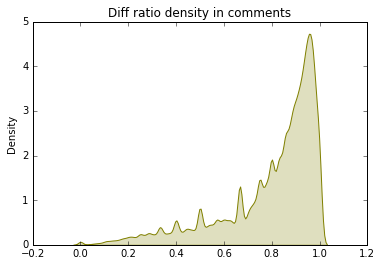

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns
sns.kdeplot(diff_ratios, shade=True, bw=.05, color="olive").set_title('Diff ratio density in comments')

In [ ]:
# Посмотрим на абсолютное и относительное число изменений

In [ ]:
inserted_counts = []
deleted_counts = []
rel_deleted_counts = []
rel_inserted_counts = []
rel_changes = []
changes = []
for data in cup_data:
  old = data['old_comment_tokens']
  new = data['new_comment_tokens']
  if len(old) == 0 or len(new) == 0:
    continue
  inserted, deleted = understand_opcode(SequenceMatcher(None, old, new).get_opcodes())
  inserted_counts.append(inserted)
  deleted_counts.append(deleted)
  rel_deleted_counts.append(deleted / len(old))
  rel_inserted_counts.append(inserted / len(old))
  changes.append(inserted + deleted)
  rel_changes.append((inserted + deleted) / (len(old) + len(new)))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Insertion and deletions in comments')

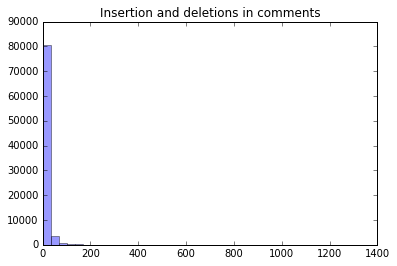

In [ ]:
sns.distplot(changes, bins=40, kde=False, rug=False).set_title('Insertion and deletions in comments')
# очень шумный график

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Insertion and deletions in comments 0.96 interval')

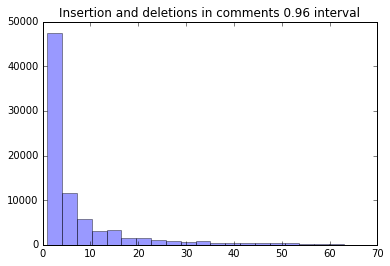

In [ ]:
def bound_data(data, alpha=0.02):
  qmax = np.quantile(changes, 1 - alpha)
  qmin = np.quantile(changes, alpha)
  bdata = np.array(data)
  bdata = bdata[bdata < qmax]
  bdata = bdata[bdata > qmin]
  return bdata

sns.distplot(bound_data(changes), bins=20, kde=False, rug=False).set_title('Insertion and deletions in comments 0.96 interval')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.05 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Rel changes density in comments')

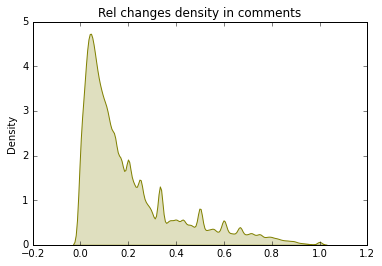

In [ ]:
sns.kdeplot(rel_changes, shade=True, bw=.05, color="olive").set_title('Rel changes density in comments')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Insertions count in comments 0.96 interval')

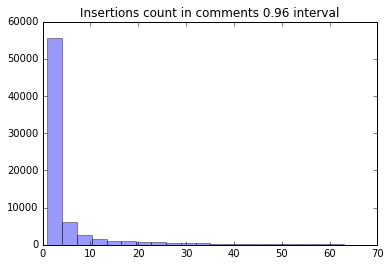

In [ ]:
sns.distplot(bound_data(inserted_counts), bins=20, kde=False, rug=False).set_title('Insertions count in comments 0.96 interval')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Deletions count in comments 0.96 interval')

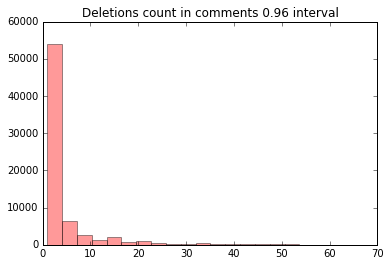

In [ ]:
sns.distplot(bound_data(deleted_counts, 0.02), bins=20, color="red", kde=False, rug=False).set_title('Deletions count in comments 0.96 interval')

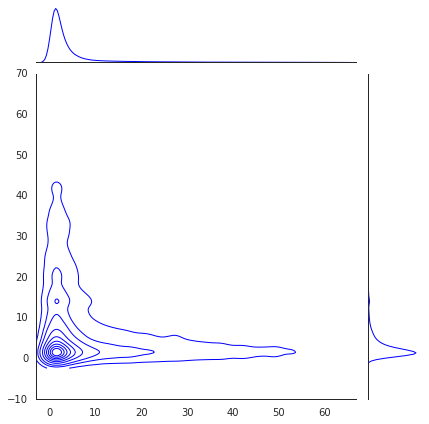

In [ ]:
x = bound_data(inserted_counts)
y = bound_data(deleted_counts)
x = x[:min(len(x), len(y))]
y = y[:min(len(x), len(y))]
with sns.axes_style('white'):
    sns.jointplot(x=x, y=y, kind='kde');

In [ ]:
changes = np.array(changes)
# Очень много данных, где комментарий меняется только в одном токене
print(len(changes[changes <= 1]), len(changes))

11286 85653


In [ ]:
# Посмотрим на те же статистики в изменениях кода

In [ ]:
inserted_counts = []
deleted_counts = []
rel_deleted_counts = []
rel_inserted_counts = []
rel_changes = []
changes = []
for data in cup_data:
  edit = data['code_change_seq']
  inserted, deleted = len(list(filter(lambda x: x[2] == 'insert', edit))), len(list(filter(lambda x: x[2] == 'delete', edit)))
  replaced = len(list(filter(lambda x: x[2] == 'replace', edit)))
  inserted += replaced
  deleted += replaced
  inserted_counts.append(inserted)
  deleted_counts.append(deleted)
  rel_deleted_counts.append(deleted / len(edit))
  rel_inserted_counts.append(inserted / len(edit))
  changes.append(inserted + deleted)
  rel_changes.append((inserted + deleted) / (len(edit)))

KeyboardInterrupt: ignored

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Insertion and deletions in code 0.96 interval')

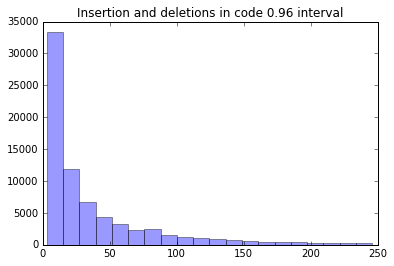

In [ ]:
sns.distplot(bound_data(changes), bins=20, kde=False, rug=False).set_title('Insertion and deletions in code 0.96 interval')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.05 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Rel changes density in code')

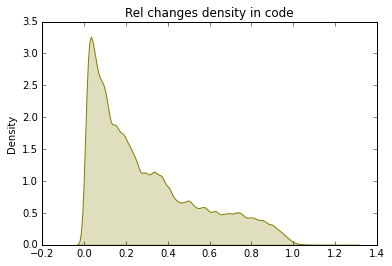

In [ ]:
sns.kdeplot(rel_changes, shade=True, bw=.05, color="olive").set_title('Rel changes density in code')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Insertions count in code 0.96 interval')

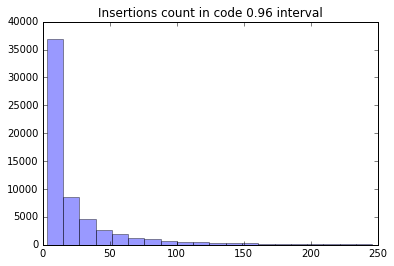

In [ ]:
sns.distplot(bound_data(inserted_counts), bins=20, kde=False, rug=False).set_title('Insertions count in code 0.96 interval')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Deletions count in code 0.96 interval')

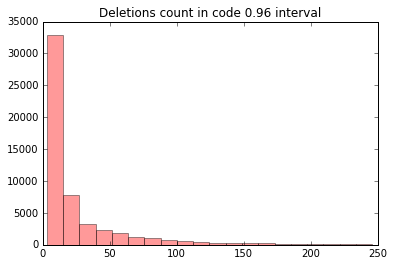

In [ ]:
sns.distplot(bound_data(deleted_counts), bins=20, color="red", kde=False, rug=False).set_title('Deletions count in code 0.96 interval')

In [ ]:
changes = np.array(changes)
# Очень много данных, где код меняется только в двух токенах
print(len(changes[changes <= 2]), len(changes))

11050 85657


In [ ]:
# давайте посмотрим на длины кода и комментариев
from tqdm import tqdm
code_lens = []
comment_lens = []
for data in tqdm(cup_data, position=0):
  M1 = data['dst_method']
  M2 = data['src_method']
  C1 = data['src_javadoc']
  C2 = data['dst_javadoc']
  M1, C1 = process_code_comment(M1, C1)
  M2, C2 = process_code_comment(M2, C2)
  code_lens.append(len(M1))
  code_lens.append(len(M2))
  comment_lens.append(len(C1))
  comment_lens.append(len(C2))

100%|██████████| 85657/85657 [05:28<00:00, 261.06it/s]


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Insertions count in code 0.96 interval')

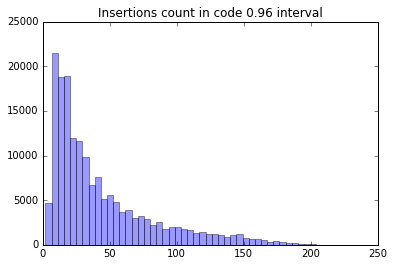

In [ ]:
sns.distplot(code_lens, bins=50, kde=False, rug=False).set_title('Insertions count in code 0.96 interval')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Insertions count in code 0.96 interval')

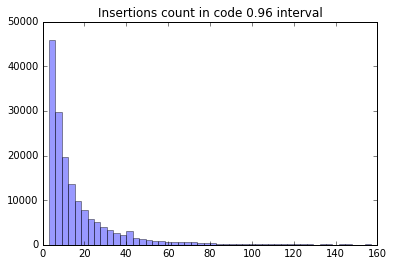

In [ ]:
sns.distplot(bound_data(comment_lens, 0.05), bins=50, kde=False, rug=False).set_title('Insertions count in code 0.96 interval')

In [ ]:
comment_lens = np.array(comment_lens)
print(np.quantile(comment_lens, 0.8))
print(len(comment_lens[comment_lens <= 25]), len(comment_lens), 100 * len(comment_lens[comment_lens <= 25]) / len(comment_lens))

25.0
138230 171314 80.68809320896132


In [ ]:
code_lens = np.array(code_lens)
print(np.quantile(code_lens, 0.8))

70.0


Итого, что мы увидели

*   ~10% комментариев меняются в <= 1 токене
*   ~10% кода меняется в <= 2 токенах
*   ~80% комментариев длиной <= 25
*   ~80% кода имеет длину <= 75



In [ ]:
# Удалим ненужные статистики, чтобы не занимать память
del changes
del rel_changes
del rel_deleted_counts
del rel_inserted_counts
del deleted_counts
del inserted_counts
import gc
gc.collect()

27482

In [ ]:
# давайте посмотрим на длины кода и комментариев
from tqdm import tqdm
from collections import Counter
code_vocab = set()
comment_vocab = set()
code_counter = Counter()
comment_counter = Counter()
for data in tqdm(cup_data,  position=0):
  M1 = data['dst_method']
  M2 = data['src_method']
  C1 = data['src_javadoc']
  C2 = data['dst_javadoc']
  M1, C1 = process_code_comment(M1, C1)
  M2, C2 = process_code_comment(M2, C2)
  code_vocab = code_vocab.union(M1)
  code_vocab = code_vocab.union(M2)
  code_counter |= Counter(M1)
  code_counter |= Counter(M2)
  comment_counter |= Counter(C1)
  comment_counter |= Counter(C2)
  comment_vocab = comment_vocab.union(C1)
  comment_vocab = comment_vocab.union(C2)


100%|██████████| 85657/85657 [11:07<00:00, 128.34it/s]


In [ ]:
len(code_vocab), len(comment_vocab), len(code_vocab.intersection(comment_vocab)) / len(code_vocab.union(comment_vocab))

(18876, 13674, 0.3763213530655391)

In [ ]:
code_counter.most_common(100)

[('css', 64),
 ('atom', 62),
 ('type', 61),
 ('out', 57),
 ('left', 56),
 ('right', 56),
 ('step', 52),
 ('menu', 52),
 ('column', 51),
 ('opcod', 50),
 ('instrument', 48),
 ('read', 47),
 ('bucket', 47),
 ('member', 47),
 ('suit', 47),
 ('resourc', 46),
 ('rate', 46),
 ('test', 45),
 ('workflow', 45),
 ('view', 44),
 ('messag', 44),
 ('header', 44),
 ('db', 44),
 ('empir', 44),
 ('key', 43),
 ('file', 43),
 ('option', 43),
 ('sourc', 43),
 ('command', 43),
 ('node', 43),
 ('peer', 43),
 ('smiley', 43),
 ('state', 42),
 ('user', 42),
 ('handler', 42),
 ('templat', 42),
 ('citi', 42),
 ('aggreg', 42),
 ('pipe', 42),
 ('name', 41),
 ('client', 41),
 ('comment', 41),
 ('annot', 41),
 ('rule', 41),
 ('gl', 41),
 ('show', 41),
 ('encod', 40),
 ('modifi', 40),
 ('field', 40),
 ('connect', 40),
 ('part', 40),
 ('instanc', 39),
 ('index', 39),
 ('properti', 39),
 ('imag', 39),
 ('ref', 39),
 ('slot', 39),
 ('video', 39),
 ('idx', 39),
 ('flow', 39),
 ('cue', 39),
 ('list', 38),
 ('servic', 38)

In [ ]:
print(len([1 for k, v in comment_counter.items() if v == 1]))
print(len([1 for k, v in code_counter.items() if v == 1]))

8453
6688


In [ ]:
# Давайте посемлируем комментарии, которые мало изменяются 

In [ ]:
import difflib

d = difflib.Differ()

In [ ]:
code_changes = []
comment_changes = []
for data in tqdm(cup_data, position=0):
  old_code = process_code_comment(data['src_method'], '')[0]
  new_code = process_code_comment(data['dst_method'], '')[0]
  old = process_code_comment('', data['src_javadoc'])[1]
  new = process_code_comment('', data['dst_javadoc'])[1]
  if len(old) == 0 or len(new) == 0:
    comment_changes.append(0)
    code_changes.append(0)
    continue
  inserted, deleted = understand_opcode(SequenceMatcher(None, old_code, new_code).get_opcodes())
  code_changes.append(inserted + deleted)
  inserted, deleted = understand_opcode(SequenceMatcher(None, old, new).get_opcodes())
  comment_changes.append(inserted + deleted)

100%|██████████| 85657/85657 [05:37<00:00, 254.16it/s]


In [ ]:
from termcolor import colored, cprint
def show_diff(diff):
  for diff_item in diff:
   if diff_item.startswith('+'):
     cprint(diff_item, 'green')
   elif diff_item.startswith('-'):
     cprint(diff_item, 'red')
   else:
     print(diff_item)

def show_seq_diffs(seq1, seq2):
  show_diff(d.compare(seq1, seq2))

short_mask = np.array(np.array(comment_changes) <= 1, dtype=int) | np.array(np.array(code_changes) <= 2, dtype=int)
print(sum(short_mask))
shorts = np.nonzero(short_mask)[0]
for _ in range(10):
  id = np.random.choice(shorts.reshape(-1))
  print(f"Comment change: {comment_changes[id]}, Code change: {code_changes[id]}")
  print("Comment: ", '===' * 20)
  show_seq_diffs(cup_data[id]['src_javadoc'].split('\n'), cup_data[id]['dst_javadoc'].split('\n'))
  
  print("Code: ", '===' * 20)
  show_seq_diffs(cup_data[id]['src_method'].split('\n'), cup_data[id]['dst_method'].split('\n'))

NameError: ignored

Видим, что нашлось очень много примеров 28719! , когда наш токенайзер говорит, что изменений произошло не больше одного в комментарии или не больше двух в коде. Часто это логичные изменения, например возвращаемый тип, но также часто это опечатки или какие-то странные переименования. 

In [ ]:
# 45% примеров содержат не более 2-ух изменений в комментарии
print(np.quantile(comment_changes, 0.45))
# 25 % примеров содержат не более  3-ех изменений в комментарии
print(np.quantile(code_changes, 0.25))

2.0
3.0


Посмотрим на данные из Техаса

In [ ]:
index = 100
print(texas_data[index]['old_comment'], texas_data[index]['new_comment'], sep='\n' + '-' * 75 + '\n')
print(texas_data[index]['old_code'], texas_data[index]['new_code'], sep='\n' + '-' * 75 + '\n')

the result of the api request
---------------------------------------------------------------------------
an api result object which can be used to get the result of this query .
public jsonobject post ( ) throws api exception { return make request ( api . method _ post ) ; }
---------------------------------------------------------------------------
public api result post ( ) { return setup request ( api . method _ post ) ; }


In [ ]:
from difflib import SequenceMatcher
def understand_opcode(opcode):
  inserted_count = 0
  deleted_count = 0
  for op in opcode:
    if op[0] == 'insert':
      inserted_count += op[4] - op[3]
    elif op[0] == 'replace':
      deleted_count += op[2] - op[1]
      inserted_count += op[4] - op[3]
    elif op[0] == 'delete':
      deleted_count += op[2] - op[1] 
  return inserted_count, deleted_count 
index = 11
s = SequenceMatcher(None, texas_data[index]['old_comment_tokens'], 
                    texas_data[index]['new_comment_tokens'])
s.ratio(), s.get_matching_blocks(), s.get_opcodes(), understand_opcode(s.get_opcodes())

(0.8275862068965517,
 [Match(a=0, b=0, size=8),
  Match(a=8, b=9, size=1),
  Match(a=10, b=10, size=1),
  Match(a=12, b=11, size=1),
  Match(a=13, b=13, size=1),
  Match(a=14, b=15, size=0)],
 [('equal', 0, 8, 0, 8),
  ('insert', 8, 8, 8, 9),
  ('equal', 8, 9, 9, 10),
  ('delete', 9, 10, 10, 10),
  ('equal', 10, 11, 10, 11),
  ('delete', 11, 12, 11, 11),
  ('equal', 12, 13, 11, 12),
  ('insert', 13, 13, 12, 13),
  ('equal', 13, 14, 13, 14),
  ('insert', 14, 14, 14, 15)],
 (3, 2))

In [ ]:
rel_changes = []
changes = []
for data in texas_data:
  inserted, deleted = understand_opcode(SequenceMatcher(None, data['old_comment_tokens'], 
                    data['new_comment_tokens']).get_opcodes())
  changes.append(inserted + deleted)
  rel_changes.append(2 * (inserted + deleted) / (len(data['old_comment_tokens']) + len(data['new_comment_tokens'])))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Changes count in texas comment 0.96 interval')

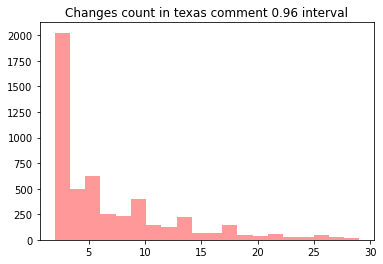

In [ ]:
import seaborn as sns
def bound_data(data, alpha=0.02):
  qmax = np.quantile(changes, 1 - alpha)
  qmin = np.quantile(changes, alpha)
  bdata = np.array(data)
  bdata = bdata[bdata < qmax]
  bdata = bdata[bdata > qmin]
  return bdata
sns.distplot(bound_data(changes), bins=20, color="red", kde=False, rug=False).set_title('Changes count in texas comment 0.96 interval')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.05 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Rel changes density in texas comments')

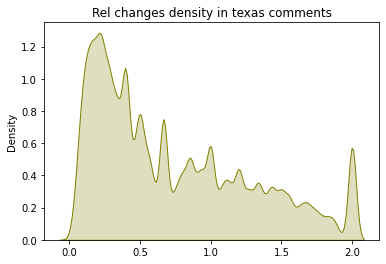

In [ ]:
sns.kdeplot(rel_changes, shade=True, bw=.05, color="olive").set_title('Rel changes density in texas comments')

In [ ]:
rel_changes = []
changes = []
for data in texas_data:
  inserted, deleted = understand_opcode(SequenceMatcher(None, data['old_code_tokens'], 
                    data['new_code_tokens']).get_opcodes())
  changes.append(inserted + deleted)
  rel_changes.append(2 * (inserted + deleted) / (len(data['old_code_tokens']) + len(data['new_code_tokens'])))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Changes count in texas code 0.96 interval')

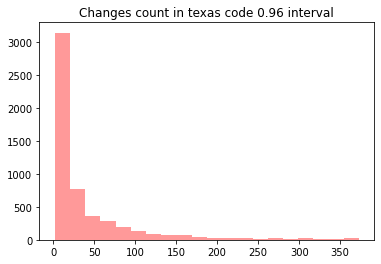

In [ ]:
sns.distplot(bound_data(changes), bins=20, color="red", kde=False, rug=False).set_title('Changes count in texas code 0.96 interval')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.05 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Rel changes density in texas code')

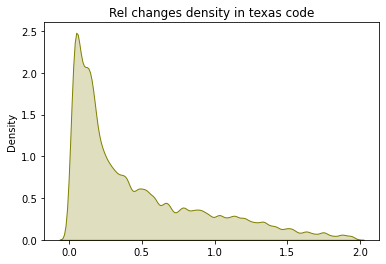

In [ ]:
sns.kdeplot(rel_changes, shade=True, bw=.05, color="olive").set_title('Rel changes density in texas code')

In [ ]:
code_changes = []
comment_changes = []
for data in texas_data:
  old = data['old_comment_tokens']
  old = list(filter(lambda x: x.isalpha(), old))
  new = data['new_comment_tokens']
  new = list(filter(lambda x: x.isalpha(), new))
  old_code = data['old_code_tokens']
  new_code = data['new_code_tokens']
  old_code = list(filter(lambda x: x.isalpha(), old_code))
  new_code = list(filter(lambda x: x.isalpha(), new_code))
  inserted, deleted = understand_opcode(SequenceMatcher(None, old_code, new_code).get_opcodes())
  code_changes.append(inserted + deleted)
  inserted, deleted = understand_opcode(SequenceMatcher(None, old, new).get_opcodes())
  comment_changes.append(inserted + deleted)

In [ ]:
import difflib

d = difflib.Differ()
from termcolor import colored, cprint
def show_diff(diff):
  for diff_item in diff:
   if diff_item.startswith('+'):
     cprint(diff_item, 'green')
   elif diff_item.startswith('-'):
     cprint(diff_item, 'red')
   else:
     print(diff_item)

def show_seq_diffs(seq1, seq2):
  show_diff(d.compare(seq1, seq2))

short_mask = np.array(np.array(comment_changes) <= 1, dtype=int) | np.array(np.array(code_changes) <= 2, dtype=int)
print(sum(short_mask), len(short_mask))
shorts = np.nonzero(short_mask)[0]
for _ in range(10):
  id = np.random.choice(shorts.reshape(-1))
  old = texas_data[id]['old_comment_tokens']
  old = list(filter(lambda x: x.isalpha(), old))
  new = texas_data[id]['new_comment_tokens']
  new = list(filter(lambda x: x.isalpha(), new))
  old_code = texas_data[id]['old_code_tokens']
  new_code = texas_data[id]['new_code_tokens']
  old_code = list(filter(lambda x: x.isalpha(), old_code))
  new_code = list(filter(lambda x: x.isalpha(), new_code))
  print(f"Comment change: {comment_changes[id]}, Code change: {code_changes[id]}")
  print("Comment: ", '===' * 20)
  show_seq_diffs(old, new)
  
  print("Code: ", '===' * 20)
  show_seq_diffs(old_code, new_code)

1507 5791
Comment change: 36, Code change: 1
Comment:  ============================================================
  current
  position
- state
  within
  range
  where
  is
  for
  initial
  from
  position
  and
  is
  for
  final
  to
  position
+ note
+ that
+ final
+ position
+ can
+ be
+ changed
+ by
+ set
+ to
+ state
+ state
+ float
+ so
+ if
+ you
+ need
+ to
+ have
+ real
+ value
+ of
+ final
+ position
+ instead
+ of
+ then
+ you
+ need
+ to
+ use
+ get
+ to
+ position
+ method
Code:  ============================================================
  public
  float
  get
  position
  state
  return
  position
- state
Comment change: 2, Code change: 2
Comment:  ============================================================
  a
  ftp
  file
- payload
+ attributes
  or
  null
  if
  it
  doesn
  t
  exists
Code:  ============================================================
  protected
  ftp
  file
- payload
+ attributes
  get
  file
  string
  file
  path
  return
  get
  file
  fil

In [ ]:
# ~ 20% кода меняется на 2 токена
print(np.quantile(code_changes, 0.2))
# ~ 10% комменатриев меняется на 1 токен
print(np.quantile(comment_changes, 0.1))

2.0
1.0


In [ ]:
from tqdm import tqdm
code_vocab = set()
comment_vocab = set()
for data in tqdm(texas_data, position=0):
  C1, C2 = data['old_comment'], data['new_comment']
  M1, M2 = data['old_code'], data['new_code']
  pm1, pc1 = process_code_comment(M1, C1)
  pm2, pc2 = process_code_comment(M2, C2)
  code_vocab |= set(pm1) | set(pm2)
  comment_vocab |= set(pc1) | set(pc2)

100%|██████████| 5791/5791 [00:18<00:00, 309.73it/s]


In [ ]:
len(code_vocab), len(comment_vocab), (len(code_vocab & comment_vocab) / len(code_vocab | comment_vocab)) 

(5129, 3181, 0.4414570685169124)

# Vocab analysis

In [ ]:
!pip install fasttext

     |████████████████████████████████| 71kB 4.0MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3025467 sha256=4a40551bb333d67a58ecc7ac8fab919b57ca4dea3a3eb694356a7816a7f65a84
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext


In [ ]:
from vocab import MixVocab, Vocab
cup_vocab = Vocab.load('CUP/vocab.json')
cup_vocab.load_embeddings('CUP/vocab_embeddings.pkl')
mixvocab = MixVocab.load('CUP/mix_vocab.json')
mixvocab.load_embeddings('CUP/mix_vocab_embeddings.pkl')

In [ ]:
cup_vocab.code, cup_vocab.nl, mixvocab.token

(Vocabulary[size=38606], Vocabulary[size=21408], Vocabulary[size=44578])

In [ ]:
mixvocab.token.embeddings.shape, cup_vocab.nl.embeddings.shape

((44578, 300), (21408, 300))

In [ ]:
# давайте посмотрим на длины кода и комментариев
from tqdm import tqdm
from collections import Counter
code_vocab = set()
comment_vocab = set()
code_counter = Counter()
comment_counter = Counter()
for data in tqdm(cup_data,  position=0):
  M1 = data['dst_method']
  M2 = data['src_method']
  C1 = data['src_javadoc']
  C2 = data['dst_javadoc']
  M1, C1 = process_code_comment(M1, C1)
  M2, C2 = process_code_comment(M2, C2)
  code_vocab = code_vocab.union(M1)
  code_vocab = code_vocab.union(M2)
  code_counter |= Counter(M1)
  code_counter |= Counter(M2)
  comment_counter |= Counter(C1)
  comment_counter |= Counter(C2)
  comment_vocab = comment_vocab.union(C1)
  comment_vocab = comment_vocab.union(C2)

100%|██████████| 85657/85657 [11:42<00:00, 121.91it/s]


In [ ]:
len(code_vocab), len(comment_vocab), len(code_vocab & comment_vocab), len(code_vocab | comment_vocab)

(18876, 13674, 8900, 23650)

In [ ]:
len(comment_vocab), len(set(cup_vocab.nl.word2id.keys()) & comment_vocab)

(13674, 4177)

In [ ]:
cup_comment_set = set(cup_vocab.nl.word2id.keys())
cup_comment_set = set(map(lambda x: stemmer.stem(x.lower()), cup_comment_set))

In [ ]:
# After stemming, vocabs are very similar
len(cup_comment_set), len(comment_vocab & cup_comment_set)

(10128, 9028)

In [ ]:
# words in set difference mostly contain digits (those words I'm filtering in my tokenizer)
import random
diff = cup_comment_set - comment_vocab
print(*random.sample(diff, 20), sep='\n')
print('-' * 80)
diff = comment_vocab - cup_comment_set
print(*random.sample(diff, 10), sep='\n')

p02
10000
12h
08
gl45
p256
function5
column1
glassfishv3
ds12
ds1
fields1
conf2
03
function1
wasn
string1
431
vpls3
1x01
--------------------------------------------------------------------------------
byteabl
decmal
cobertura
acm
blks
damerau
endpoind
searchstr
configr
cappedboolean


In [ ]:
random.sample(code_vocab - comment_vocab, 10)

['mbin',
 'violenc',
 'mauric',
 'javacript',
 'jtds',
 'localtrac',
 'removebykti',
 'lstate',
 'unauthz',
 'webinfpath']

In [ ]:
split_identifiers('WebInfPath'), split_identifiers('web_inf_path')

(['Web', 'Inf', 'Path'], ['web', 'inf', 'path'])

In [ ]:
# ~ 33% of code tokens used only once
single_tokens = [token for token, count in code_counter.items() if count == 1]
len(single_tokens) 

6688

In [ ]:
comment_counter.most_common(10)

[('bucket', 103),
 ('link', 92),
 ('code', 86),
 ('valu', 67),
 ('instanc', 56),
 ('file', 50),
 ('attribut', 50),
 ('modul', 48),
 ('type', 44),
 ('overflow', 44)]

In [ ]:
# ~ 60% of comment tokens used only once!
single_tokens = [token for token, count in comment_counter.items() if count == 1]
len(single_tokens) 

8453

Это странно, очень много токенов из комментариев используются только один раз. Если например заменять их на `<UNK>`, то мы потеряем 60% всего словаря

In [ ]:
random.sample(single_tokens, 16)

['quickfix',
 'rehydr',
 'onelevel',
 'weaken',
 'agg',
 'generatevpnclientpackag',
 'sublcass',
 'rcs',
 'micronaut',
 'unkown',
 'virt',
 'vulkan',
 'ecl',
 'nlms',
 'berlin',
 'testcas']

In [ ]:
# Давайте посмотрим на частотные словари для токенизации, которую предлагает CUP

In [ ]:
def filter_cup_tokens(tokens):
  result = []
  for token in tokens:
    token = token.lower()
    if token.isalpha():
      result.append(token)
  return result
cup_code_counter = Counter()
cup_comment_counter = Counter()
for data in tqdm(cup_data, position=0):
  M1 = filter_cup_tokens([item[0] for item in data['code_change_seq']])
  M2 = filter_cup_tokens([item[1] for item in data['code_change_seq']])
  C1 = filter_cup_tokens(data['src_desc_tokens'])
  C2 = filter_cup_tokens(data['dst_desc_tokens'])
  cup_code_counter |= Counter(M1) | Counter(M2)
  cup_comment_counter |= Counter(C1) | Counter(C2)

100%|██████████| 85657/85657 [02:07<00:00, 672.91it/s]


In [ ]:
len(cup_code_counter), len(cup_comment_counter)

(21848, 16919)

In [ ]:
cup_code_counter.most_common(10)

[('css', 64),
 ('atom', 62),
 ('type', 61),
 ('out', 57),
 ('left', 56),
 ('right', 56),
 ('menu', 52),
 ('column', 51),
 ('suite', 47),
 ('read', 46)]

In [ ]:
single_tokens = [token for token, count in cup_code_counter.items() if count == 1]
len(single_tokens) 

6454

In [ ]:
# Этот частотный словарь построен только по первым предложениям комментариев, потому что
# Только для них есть токенизация 
cup_comment_counter.most_common(20)

[('the', 9),
 ('id', 9),
 ('lhs', 8),
 ('are', 7),
 ('version', 7),
 ('task', 7),
 ('zoom', 7),
 ('string', 6),
 ('file', 6),
 ('key', 6),
 ('b', 6),
 ('bytes', 6),
 ('generates', 6),
 ('comment', 6),
 ('secret', 6),
 ('peers', 6),
 ('interface', 5),
 ('with', 5),
 ('name', 5),
 ('or', 5)]

In [ ]:
# ~80% of tokens in CUP description comments are used only once
single_tokens = [token for token, count in cup_comment_counter.items() if count == 1]
len(single_tokens) 

13175

In [ ]:
random.sample(single_tokens, 12)

['kickstarts',
 'algrebra',
 'respond',
 'road',
 'javafile',
 'cram',
 'raster',
 'itemstack',
 'propertys',
 'childe',
 'genomic',
 'papx']

In [ ]:
random.sample(set(cup_comment_counter.keys()) - set(single_tokens), 10)

['am',
 'within',
 'easy',
 'style',
 'sequences',
 'tidy',
 'hash',
 'uncompress',
 'vect',
 'superclass']

В итоге, как не токенизируй, очень много слов из комментариев встречаются только раз. Кроме этого, если сэмплировать эти слова, они какие-то все очень странные. 

In [ ]:
# Уникальные слова используются даже чаще, чем не уникальные 
sum(cup_comment_counter.values()), len(single_tokens)

(21941, 13175)

Посмотрим на данные из техаса

In [ ]:
def filter_texas_tokens(tokens, stem=False):
  result = []
  for token in tokens:
    token = token.lower()
    if token.isalpha():
      if stem:
        result.append(stemmer.stem(token))
      else:  
        result.append(token)
  return result

texas_comment_vocab = set()
texas_code_vocab = set()
texas_code_counter = Counter()
texas_comment_counter = Counter()
for data in texas_data:
  C1 = filter_texas_tokens(data['old_comment_tokens'])
  C2 = filter_texas_tokens(data['new_comment_tokens'])
  M1 = filter_texas_tokens(data['old_code_tokens'])
  M2 = filter_texas_tokens(data['new_code_tokens'])
  texas_comment_vocab |= set(C1) | set(C2)
  texas_comment_counter |= Counter(C1) | Counter(C2)
  texas_code_vocab |= set(M1) | set(M2)
  texas_code_counter |= Counter(M1) | Counter(M2)

In [ ]:
len(texas_code_vocab), len(texas_comment_vocab), len(texas_code_vocab & texas_comment_vocab)

(6787, 4608, 3392)

In [ ]:
texas_comment_counter.most_common(10)

[('method', 16),
 ('type', 16),
 ('the', 12),
 ('parameter', 12),
 ('address', 9),
 ('size', 8),
 ('argument', 8),
 ('reference', 8),
 ('download', 7),
 ('time', 6)]

In [ ]:
texas_code_counter.most_common(10)

[('m', 175),
 ('value', 174),
 ('operator', 122),
 ('date', 82),
 ('token', 82),
 ('report', 81),
 ('str', 80),
 ('is', 78),
 ('if', 77),
 ('app', 75)]

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Changes count in texas code 0.96 interval')

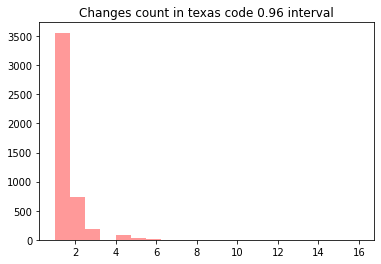

In [ ]:
import seaborn as sns
sns.distplot(list(texas_comment_counter.values()), bins=20, color="red", kde=False, rug=False).set_title('Frequency of tokens in texas comments')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Frequency of tokens in texas code')

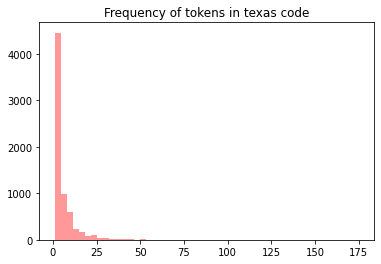

In [ ]:
import seaborn as sns
sns.distplot(list(texas_code_counter.values()), bins=50, color="red", kde=False, rug=False).set_title('Frequency of tokens in texas code')

In [ ]:
# ~75% of tokens in texas (not stemmed) comments used once 
single_tokens = [token for token, count in texas_comment_counter.items() if count == 1]
len(single_tokens) 

3560

In [ ]:
random.sample(single_tokens, 10)

['concerning',
 'port',
 'conjunction',
 'creates',
 'idata',
 'configurations',
 'jtable',
 'threaded',
 'ends',
 'jtest']

In [ ]:
# ~ 20% of code tokens used once 
single_tokens = [token for token, count in texas_code_counter.items() if count == 1]
len(single_tokens) 

1808

Давайте попробуем использовать стеммер

In [ ]:
texas_comment_vocab = set()
texas_code_vocab = set()
texas_code_counter = Counter()
texas_comment_counter = Counter()
for data in texas_data:
  C1 = filter_texas_tokens(data['old_comment_tokens'], stem=True)
  C2 = filter_texas_tokens(data['new_comment_tokens'], stem=True)
  M1 = filter_texas_tokens(data['old_code_tokens'], stem=True)
  M2 = filter_texas_tokens(data['new_code_tokens'], stem=True)
  texas_comment_vocab |= set(C1) | set(C2)
  texas_comment_counter |= Counter(C1) | Counter(C2)
  texas_code_vocab |= set(M1) | set(M2)
  texas_code_counter |= Counter(M1) | Counter(M2)

In [ ]:
# Размер словаря комментариев сильно уменьшился (с 4608 до 3296)
len(texas_code_vocab), len(texas_comment_vocab), len(texas_code_vocab & texas_comment_vocab)

(5131, 3295, 2632)

In [ ]:
texas_comment_counter.most_common(10)

[('method', 16),
 ('type', 16),
 ('the', 12),
 ('paramet', 12),
 ('address', 9),
 ('size', 8),
 ('argument', 8),
 ('refer', 8),
 ('move', 8),
 ('link', 7)]

In [ ]:
texas_code_counter.most_common(10)

[('m', 175),
 ('valu', 174),
 ('oper', 122),
 ('properti', 98),
 ('date', 82),
 ('token', 82),
 ('report', 81),
 ('str', 80),
 ('is', 78),
 ('if', 77)]

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Frequency of tokens in texas comments')

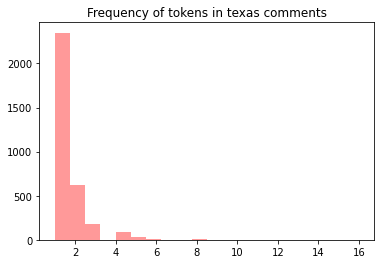

In [ ]:
import seaborn as sns
sns.distplot(list(texas_comment_counter.values()), bins=20, color="red", kde=False, rug=False).set_title('Frequency of tokens in texas comments')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Frequency of tokens in texas code')

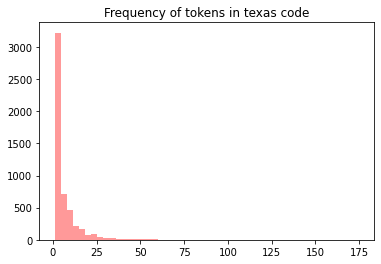

In [ ]:
import seaborn as sns
sns.distplot(list(texas_code_counter.values()), bins=50, color="red", kde=False, rug=False).set_title('Frequency of tokens in texas code')

In [ ]:
# ~71% of tokens in texas (not stemmed) comments used once 
single_tokens = [token for token, count in texas_comment_counter.items() if count == 1]
len(single_tokens) 

2349

In [ ]:
random.sample(single_tokens, 20)

['uriimpl',
 'qlfield',
 'idt',
 'picker',
 'lhex',
 'fss',
 'miranda',
 'stringifi',
 'tempor',
 'er',
 'atan',
 'springframework',
 'isourc',
 'mu',
 'startend',
 'colonifi',
 'failov',
 'ioruntim',
 'unsync',
 'invari']

In [ ]:
# ~ 20% of code tokens used once 
single_tokens = [token for token, count in texas_code_counter.items() if count == 1]
len(single_tokens) 

1288